<a href="https://colab.research.google.com/github/AriaRahman/CVPR/blob/main/assignment_1_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving animal_dataset.zip to animal_dataset.zip


In [ ]:
import zipfile
import os

zip_path = "animal_dataset.zip"
extract_path = "animal_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", os.listdir(extract_path))


Extracted to: ['animal_dataset']


In [ ]:
import os

base_path = "/content/animal_dataset/animal_dataset"
print(os.listdir(base_path))


['panda', 'dog', 'cat']


In [ ]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import math

In [ ]:
base_path = "/content/animal_dataset/animal_dataset"
classes = ['panda', 'dog', 'cat']

data = []
labels = []

for label_index, class_name in enumerate(classes):
    pattern = f"{base_path}/{class_name}/*"
    for img_path in glob.glob(pattern):
        try:
            img = Image.open(img_path).convert("L")
            img = img.resize((32, 32))
            flat = np.array(img).flatten()
            data.append(flat)
            labels.append(label_index)
        except:
            continue

data = np.array(data)
labels = np.array(labels)

print("Dataset shape:", data.shape)
print("Labels shape:", labels.shape)

Dataset shape: (300, 1024)
Labels shape: (300,)


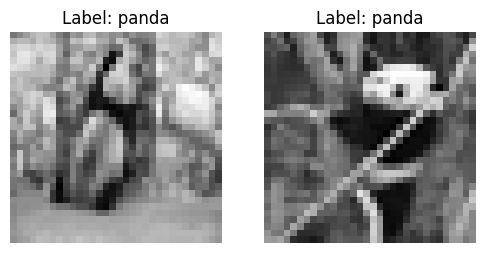

In [ ]:


# Pick two random indices
idx1, idx2 = 0, 1  # or random.sample(range(len(data)), 2)

# Reshape the flattened images back to 32x32 for display
img1 = data[idx1].reshape(32, 32)
img2 = data[idx2].reshape(32, 32)

# Get their labels
label1 = labels[idx1]
label2 = labels[idx2]

# Plot them
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.title(f"Label: {classes[label1]}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')
plt.title(f"Label: {classes[label2]}")
plt.axis('off')

plt.show()


In [ ]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))


In [11]:
def knn_predict(train_data, train_labels, test_instance, k, distance_func):
    distances = []
    for i in range(len(train_data)):
        dist = distance_func(test_instance, train_data[i])
        distances.append((dist, train_labels[i]))

    # sort by distance
    distances.sort(key=lambda x: x[0])

    # get top k labels
    top_k = [label for _, label in distances[:k]]

    # majority vote
    prediction = max(set(top_k), key=top_k.count)
    return prediction




In [12]:
# -----------------------------
# STEP 4: 5-Fold Cross Validation
# -----------------------------
def cross_validate(data, labels, k_values, distance_func):
    fold_size = len(data) // 5
    indices = np.arange(len(data))
    np.random.shuffle(indices)

    accuracies = {k: [] for k in k_values}

    for fold in range(5):
        start = fold * fold_size
        end = start + fold_size if fold != 4 else len(data)
        val_idx = indices[start:end]
        train_idx = np.concatenate([indices[:start], indices[end:]])

        train_data = data[train_idx]
        train_labels = labels[train_idx]
        val_data = data[val_idx]
        val_labels = labels[val_idx]

        for k in k_values:
            correct = 0
            for i in range(len(val_data)):
                pred = knn_predict(train_data, train_labels, val_data[i], k, distance_func)
                if pred == val_labels[i]:
                    correct += 1
            acc = correct / len(val_data)
            accuracies[k].append(acc)

    # compute average accuracy per k
    avg_accuracies = {k: np.mean(accuracies[k]) for k in k_values}
    return avg_accuracies




In [13]:
# -----------------------------
# STEP 5: Run cross-validation for L1 and L2
# -----------------------------
k_values = [1, 3, 5, 7, 9, 11]

print("Running 5-fold cross-validation... (this may take a few minutes)")

l1_results = cross_validate(data, labels, k_values, manhattan_distance)
l2_results = cross_validate(data, labels, k_values, euclidean_distance)

print("L1 Accuracies:", l1_results)
print("L2 Accuracies:", l2_results)




Running 5-fold cross-validation... (this may take a few minutes)
L1 Accuracies: {1: np.float64(0.38666666666666666), 3: np.float64(0.42000000000000004), 5: np.float64(0.3933333333333333), 7: np.float64(0.3833333333333333), 9: np.float64(0.38333333333333336), 11: np.float64(0.42000000000000004)}
L2 Accuracies: {1: np.float64(0.33), 3: np.float64(0.37333333333333335), 5: np.float64(0.40666666666666673), 7: np.float64(0.38333333333333336), 9: np.float64(0.40666666666666673), 11: np.float64(0.46333333333333326)}


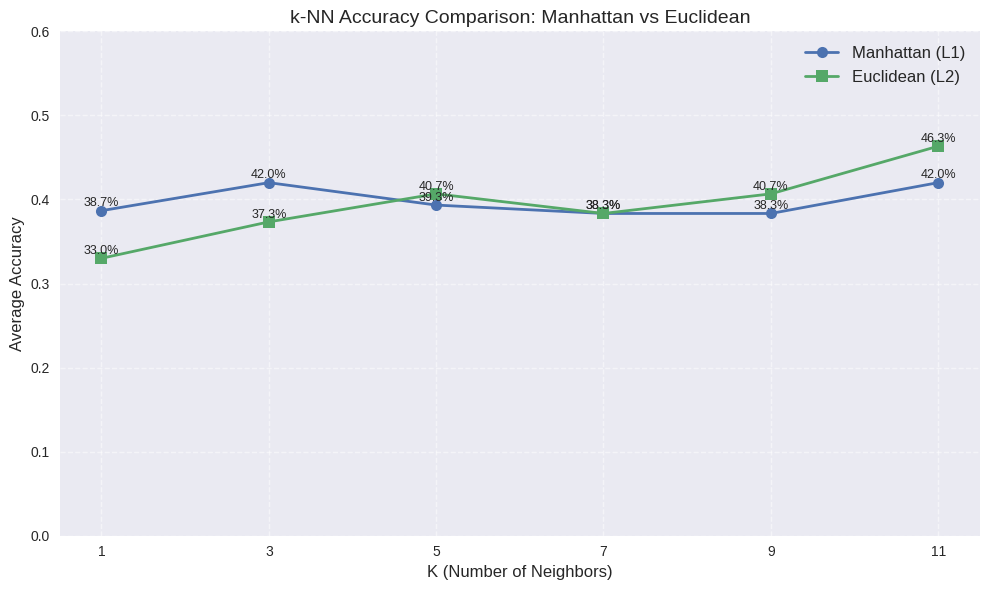

In [31]:

fig, ax = plt.subplots(figsize=(10, 6))

# Plot L1 and L2 accuracies
ax.plot(k_values, [l1_results[k] for k in k_values], marker='o', linewidth=2, markersize=8, label='Manhattan (L1)')
ax.plot(k_values, [l2_results[k] for k in k_values], marker='s', linewidth=2, markersize=8, label='Euclidean (L2)')

# Annotate points with exact accuracy
for i, k in enumerate(k_values):
    ax.text(k, l1_results[k] + 0.005, f"{l1_results[k]*100:.1f}%", ha='center', fontsize=9)
    ax.text(k, l2_results[k] + 0.005, f"{l2_results[k]*100:.1f}%", ha='center', fontsize=9)

# Labels and title
ax.set_xlabel("K (Number of Neighbors)", fontsize=12)
ax.set_ylabel("Average Accuracy", fontsize=12)
ax.set_title("k-NN Accuracy Comparison: Manhattan vs Euclidean", fontsize=14)
ax.set_xticks(k_values)
ax.set_ylim(0, 0.6)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


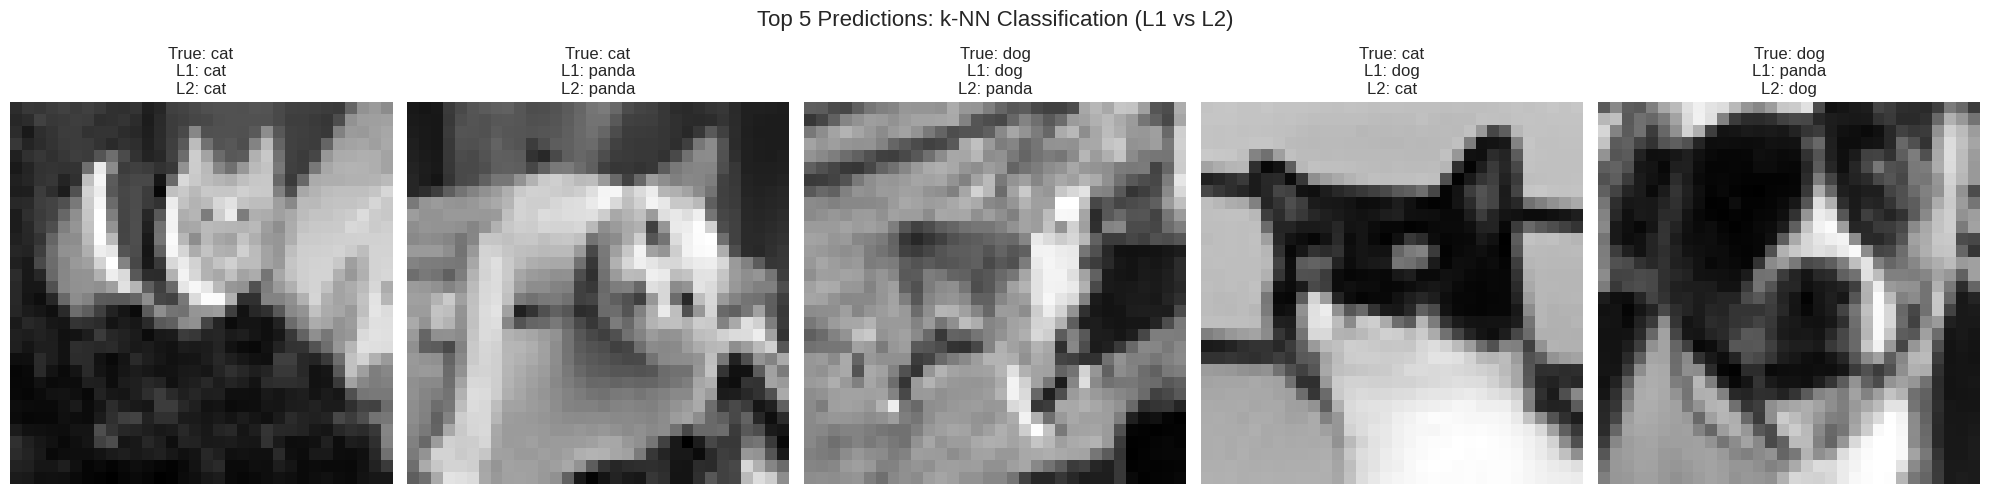

In [30]:
# -----------------------------
# STEP 7: Top 5 Predictions


# Pick 5 random images from the dataset
random_indices = random.sample(range(len(data)), 5)

# Create subplots: 1 row, 5 columns
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    img_vector = data[idx]
    true_label = labels[idx]

    # Make predictions for both distances
    pred_l1 = knn_predict(data, labels, img_vector, k=3, distance_func=manhattan_distance)
    pred_l2 = knn_predict(data, labels, img_vector, k=3, distance_func=euclidean_distance)

    # Reshape vector to 32x32 grayscale image
    img_display = img_vector.reshape(32, 32)

    # Display image
    axs[i].imshow(img_display, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"True: {classes[true_label]}\nL1: {classes[pred_l1]}\nL2: {classes[pred_l2]}", fontsize=12)

plt.suptitle("Top 5 Predictions: k-NN Classification (L1 vs L2)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.9])  # leave space for suptitle
plt.show()
